# Comparing Random vs Non Random data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(12,5)})
%load_ext autoreload
%autoreload 2

In [2]:
import re
# from tqdm import tqdm
from tqdm.notebook import trange, tqdm

In [3]:
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from lnds import longest_non_decreasing_subsequence as lnds
from hard_rules import denoised_fraction, version_serializtion


In [124]:
data = pd.read_parquet("../Data/random_10k.parquet")

In [125]:
data = data[data["maid"]=='7']

## Filtering
1. Non houses 
2. Cookies with mixed constant 
3. Cookies which are assigned to a house which they do not apepar in

In [128]:
data = data[~data['is_hh']]

In [129]:
unique_values_per_cookie = data.groupby(["hh_id", "iiqid"])[["timestamp", "brand", "model", "os", "browser", "advertisedbrowser"]].nunique()

In [130]:
unique_values_per_cookie["sum"] = unique_values_per_cookie.iloc[:,1:].sum(axis=1)

In [131]:
equal_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]==5]
more_than_5 = unique_values_per_cookie[unique_values_per_cookie["sum"]>5]

In [132]:
mixed_iiqids = more_than_5.index.get_level_values(level=1).to_list()

In [133]:
data = data[~data['iiqid'].isin(mixed_iiqids)]

In [134]:
misplaced_series = ~data.groupby('iiqid')['is_house_ip_or_source_ip'].any()
misplaced_iiqids = misplaced_series[misplaced_series].index.values

In [135]:
data = data[~data['iiqid'].isin(misplaced_iiqids)]

## Creating relevant tables
- Random pairs
- Cookies time data
- Cookies version noise data

In [136]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [137]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [234]:
filtered = data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [235]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [236]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [237]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [142]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [143]:
two_from_each_houe = grouped.groupby(observed=True, level=0, group_keys=False).apply(lambda g: g.sample(2))

In [144]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [145]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [146]:
cookie_time = data.groupby('iiqid')['time'].agg(['min', 'max'])

In [147]:
cookie_time['interval'] = (cookie_time['max'] - cookie_time['min']).apply(lambda t: t.days)

In [148]:
noises = data.groupby('iiqid').apply(denoised_fraction)

In [149]:
noises = noises.rename('noise')

### A single pair

- Time interval first
- Time interval second
- Time between end first and start second(maybe after remove outliers)
- Time interval we looked at (can check options)
- Number of points min
- Number of points max
- UA version error
- Overlap errors that we calculate

In [150]:
random_cookie_1 = np.random.choice(data['iiqid'].unique())
random_cookie_2 = np.random.choice(data['iiqid'].unique())

In [151]:
size1 = len(data[data['iiqid']==random_cookie_1])
size2 = len(data[data['iiqid']==random_cookie_2])

In [152]:
single_row = pd.DataFrame({'id1': [random_cookie_1], 'id2': [random_cookie_2], 
              'min_size': min(size1, size2), 'max_size':max(size1, size2)})

In [153]:
single_row = single_row.merge(cookie_time, left_on='id1', right_index=True)
single_row = single_row.merge(cookie_time, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [154]:
single_row = single_row.merge(noises, left_on='id1', right_index=True)
single_row = single_row.merge(noises, left_on='id2', right_index=True, 
                              suffixes=('_id1', '_id2'))

In [155]:
single_row

id1         id2  min_size  max_size                 min_id1  \
0  OW39FM2amE  2sMOSv7I8k         1         9 2023-01-24 11:10:16.182   

                  max_id1  interval_id1                 min_id2  \
0 2023-02-21 06:14:09.786            27 2023-01-30 05:54:04.114   

                  max_id2  interval_id2  noise_id1  noise_id2  
0 2023-01-30 05:54:04.114             0        1.0        1.0

### Random Data

In [156]:
noise_of_pairs = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for house in tqdm(trial_pairs.index):
    iiqid_0, iiqid_1 = trial_pairs.loc[house].values
    pair_data = filtered[(filtered['hh_id']==house) 
                     & ((filtered['iiqid']==iiqid_0) 
                        | (filtered['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs['first'].append(iiqid_0)
    noise_of_pairs['second'].append(iiqid_1)
noise_of_pairs_df = pd.DataFrame(noise_of_pairs)

  0%|          | 0/1330 [00:00<?, ?it/s]

In [157]:
random_trial_data = noise_of_pairs_df.merge(cookie_time, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [158]:
random_trial_data = random_trial_data.merge(noises, left_on='first', right_index=True)
random_trial_data = random_trial_data.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [159]:
random_trial_data['min_size'] = random_trial_data[['size_0','size_1']].min(axis=1)
random_trial_data['max_size'] = random_trial_data[['size_0','size_1']].max(axis=1)

In [160]:
random_trial_data = random_trial_data.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [161]:
random_trial_data['min_interval'] = random_trial_data[['interval_0', 'interval_1']].min(axis=1)
random_trial_data['max_interval'] = random_trial_data[['interval_0', 'interval_1']].max(axis=1)

random_trial_data['min_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data['max_vers_clean'] = random_trial_data[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [162]:
random_trial_data.describe().transpose()

count       mean         std       min        25%        50%  \
merge_noise     1330.0   0.130363    0.140991  0.000000   0.012525   0.071429   
size_0          1330.0  42.560902   81.125276  1.000000   2.000000  12.000000   
size_1          1330.0  43.635338   89.539958  1.000000   2.000000  12.000000   
interval_0      1330.0  35.803759   33.247887  0.000000   0.000000  30.000000   
interval_1      1330.0  35.887970   33.433315  0.000000   0.000000  30.000000   
vers_clean_0    1330.0   0.998322    0.013718  0.666667   1.000000   1.000000   
vers_clean_1    1330.0   0.998235    0.014149  0.666667   1.000000   1.000000   
min_size        1330.0  13.148872   24.894941  1.000000   1.000000   3.000000   
max_size        1330.0  73.047368  110.382378  1.000000  11.000000  36.000000   
min_interval    1330.0  18.687218   26.092154  0.000000   0.000000   1.000000   
max_interval    1330.0  53.004511   30.872806  0.000000  28.000000  62.000000   
min_vers_clean  1330.0   0.996629    0.019508  0.666667   1.000000   1.000000   
max_vers_clean  1330.0   0.999928    0.001547  0.955556   1.000000   1.000000   

                      75%     max  
merge_noise      0.211815     0.5  
size_0          49.000000   875.0  
size_1          45.750000  1441.0  
interval_0      69.000000    88.0  
interval_1      71.000000    88.0  
vers_clean_0     1.000000     1.0  
vers_clean_1     1.000000     1.0  
min_size        14.000000   244.0  
max_size        91.000000  1441.0  
min_interval    33.000000    87.0  
max_interval    81.000000    88.0  
min_vers_clean   1.000000     1.0  
max_vers_clean   1.000000     1.0

<AxesSubplot: >

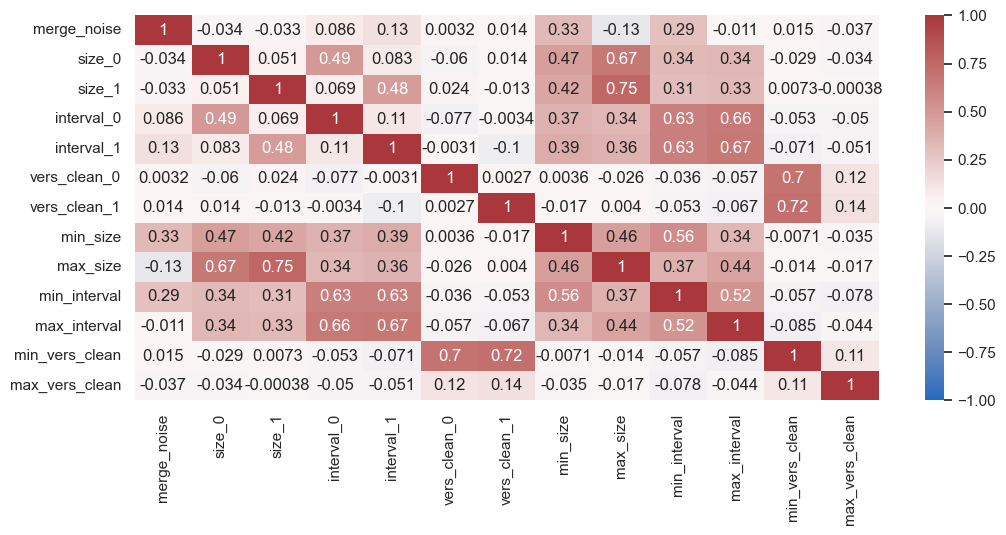

In [163]:
sns.heatmap(data=random_trial_data.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [164]:
# mins = random_trial_data[features].min()
# maxs = random_trial_data[features].max()

In [165]:
# random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1), 'merge_noise'].mean()

In [166]:
# matrix = []
# for s in range(1, 30):
#     row = []
#     for i in range(14):
#         row.append(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1), 
#                                          'merge_noise'].mean())
#     matrix.append(row)

From all the pairs which 
1. Both cookies have more instances than some threshold
2. Both cookies are lived more than somethreshold
3. Both cookies have version consistency more than some threshold  

What fraction have the the merging noise is less than some threshold?

In [167]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [168]:
# features
thresholds = [3, 7, 0.5]
noise_thresh = 0.1

In [169]:
total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= thresholds).all(axis=1)]
good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
print(len(good_aobve_thresh)/len(total_above_thresh))

0.33941605839416056


In [170]:
matrix = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix.append(row)

<AxesSubplot: >

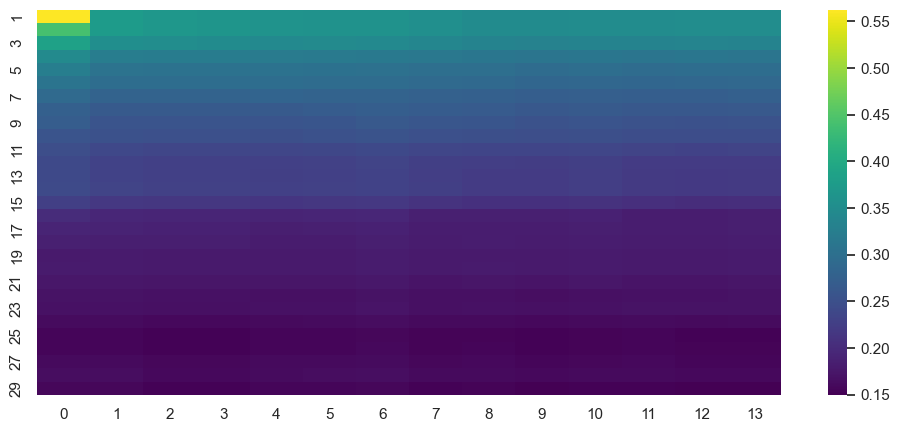

In [171]:
sns.heatmap(data=pd.DataFrame(matrix, columns=range(14), index=range(1,30)), 
            cmap='viridis')

## Non-Random Data

In [172]:
more_than_one_cooke = data.groupby(const, observed=True).filter(lambda g: g['iiqid'].nunique() > 1)

In [173]:
def pick_two_random(group):
    return np.random.choice(group.unique(), size=2)

pairs_series = more_than_one_cooke.groupby(const, observed=True)['iiqid'].agg(pick_two_random)

In [174]:
brothers_paris = pd.DataFrame.from_dict(
        dict(zip(range(len(pairs_series)), pairs_series.values))).\
        transpose()
brothers_paris.columns = ['first','second']

In [175]:
i = 0
iiqid_0, iiqid_1 = trial_pairs.iloc[i].values
print(iiqid_0, iiqid_1)

MONnq4JN4P T9zwT1qFhM


In [176]:
noise_of_pairs2 = {'merge_noise': [], 'size_0': [], 'size_1': [], 'first' :[], 'second': []}

for i in tqdm(brothers_paris.index):
    iiqid_0, iiqid_1 = brothers_paris.iloc[i].values
    pair_data = more_than_one_cooke[((more_than_one_cooke['iiqid']==iiqid_0) 
                        | (more_than_one_cooke['iiqid']==iiqid_1))].copy()
    pair_data.sort_values(by='time', inplace=True)
    serialize_id = {iiqid_0: 0, iiqid_1: 1}
    
    s, inds = lnds(pair_data['iiqid'].apply(lambda x: serialize_id[x]).values)
    not_inds = [i for i in range(len(pair_data)) if i not in inds]
    
    noise_of_pairs2['merge_noise'].append(1 - len(s) / len(pair_data))
    noise_of_pairs2['size_0'].append(sum(pair_data['iiqid']==iiqid_0))
    noise_of_pairs2['size_1'].append(sum(pair_data['iiqid']==iiqid_1))
    noise_of_pairs2['first'].append(iiqid_0)
    noise_of_pairs2['second'].append(iiqid_1)
noise_of_pairs_df2 = pd.DataFrame(noise_of_pairs2)

  0%|          | 0/2627 [00:00<?, ?it/s]

In [177]:
random_trial_data2 = noise_of_pairs_df2.merge(cookie_time, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(cookie_time, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [178]:
random_trial_data2 = random_trial_data2.merge(noises, left_on='first', right_index=True)
random_trial_data2 = random_trial_data2.merge(noises, left_on='second', right_index=True, 
                              suffixes=('_0', '_1'))

In [179]:
random_trial_data2['min_size'] = random_trial_data2[['size_0','size_1']].min(axis=1)
random_trial_data2['max_size'] = random_trial_data2[['size_0','size_1']].max(axis=1)

In [180]:
random_trial_data2 = random_trial_data2.rename(columns={'min_0': 'start_0', 'max_0': 'end_0',
                                  'min_1': 'start_1', 'max_1': 'end_1',
                                  'noise_0': 'vers_clean_0', 'noise_1': 'vers_clean_1'})

In [181]:
random_trial_data2['min_interval'] = random_trial_data2[['interval_0', 'interval_1']].min(axis=1)
random_trial_data2['max_interval'] = random_trial_data2[['interval_0', 'interval_1']].max(axis=1)

random_trial_data2['min_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].min(axis=1)
random_trial_data2['max_vers_clean'] = random_trial_data2[['vers_clean_0', 'vers_clean_1']].max(axis=1)

In [182]:
random_trial_data2.describe().transpose()

count       mean        std       min  25%   50%        75%  \
merge_noise     2627.0   0.088630   0.139919  0.000000  0.0   0.0   0.136364   
size_0          2627.0  36.585839  76.649918  1.000000  2.0  10.0  36.500000   
size_1          2627.0  34.889989  68.358028  1.000000  2.0   9.0  36.000000   
interval_0      2627.0  28.202512  31.084218  0.000000  0.0  15.0  55.000000   
interval_1      2627.0  28.253902  31.048286  0.000000  0.0  16.0  55.000000   
vers_clean_0    2627.0   0.998532   0.014183  0.600000  1.0   1.0   1.000000   
vers_clean_1    2627.0   0.997730   0.020788  0.538462  1.0   1.0   1.000000   
min_size        2627.0  21.612866  47.886295  1.000000  1.0   5.0  20.000000   
max_size        2627.0  49.862962  88.640766  1.000000  4.0  18.0  59.000000   
min_interval    2627.0  20.605634  27.875358  0.000000  0.0   2.0  38.000000   
max_interval    2627.0  35.850780  32.201535  0.000000  0.0  30.0  69.000000   
min_vers_clean  2627.0   0.997145   0.022022  0.538462  1.0   1.0   1.000000   
max_vers_clean  2627.0   0.999117   0.012112  0.600000  1.0   1.0   1.000000   

                   max  
merge_noise        0.5  
size_0          1171.0  
size_1          1008.0  
interval_0        88.0  
interval_1        88.0  
vers_clean_0       1.0  
vers_clean_1       1.0  
min_size         618.0  
max_size        1171.0  
min_interval      88.0  
max_interval      88.0  
min_vers_clean     1.0  
max_vers_clean     1.0

In [183]:
# random_trial_data2.corr(numeric_only=True)['merge_noise'][1:].plot.bar()

<AxesSubplot: >

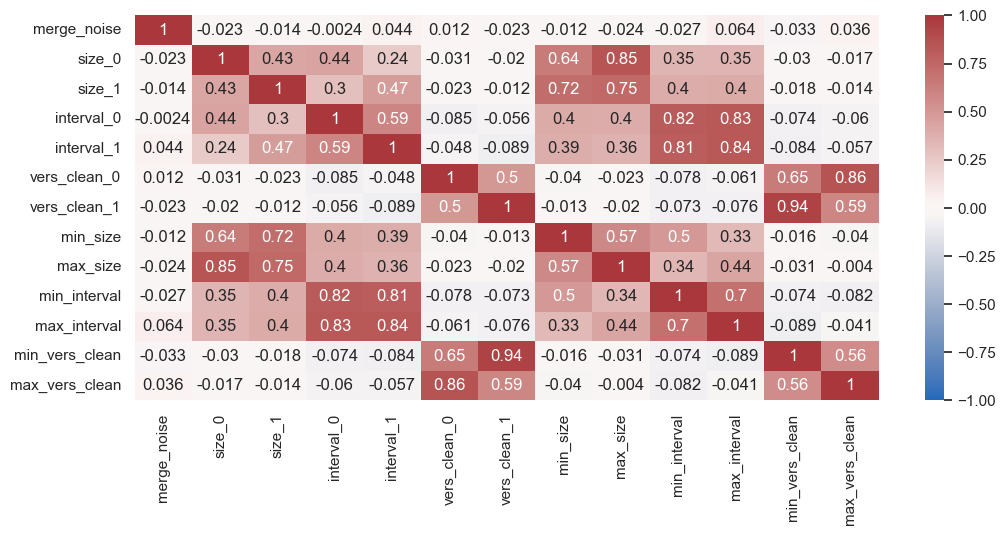

In [184]:
sns.heatmap(data=random_trial_data2.corr(numeric_only=True), annot=True, vmin=-1, vmax=1, cmap='vlag')

In [185]:
features = ['min_size', 'min_interval', 'min_vers_clean']
target = 'merge_noise'

In [186]:
matrix2 = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(good_aobve_thresh)/len(total_above_thresh))
    matrix2.append(row)

<AxesSubplot: >

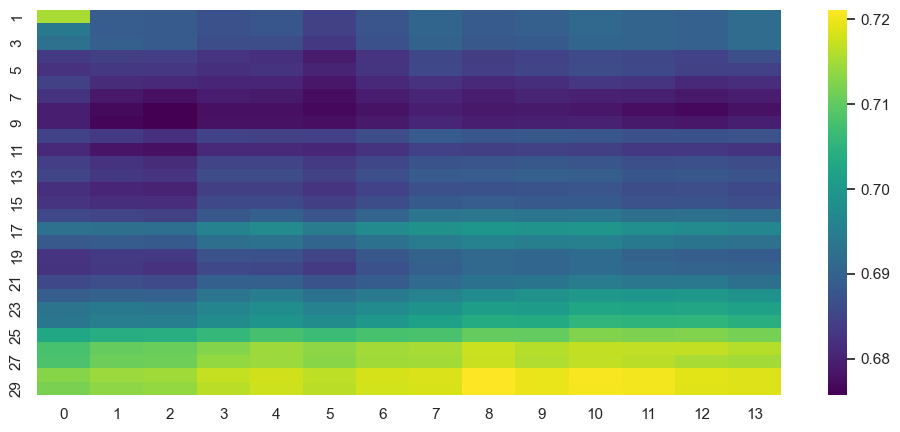

In [187]:
sns.heatmap(data=pd.DataFrame(matrix2, columns=range(14), index=range(1,30)), 
            cmap='viridis')

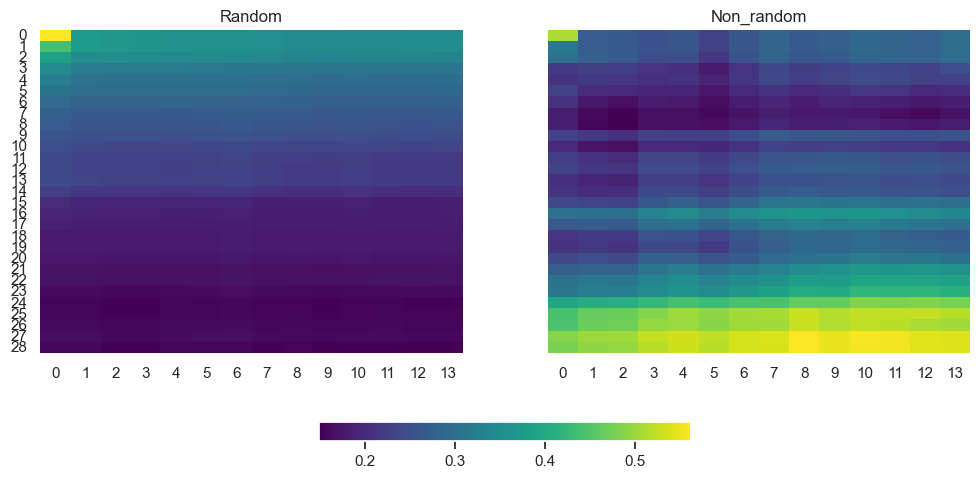

In [188]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [189]:
matrix_part = [m[:10] for m in matrix[:10]]
matrix2_part = [m[:10] for m in matrix2[:10]]

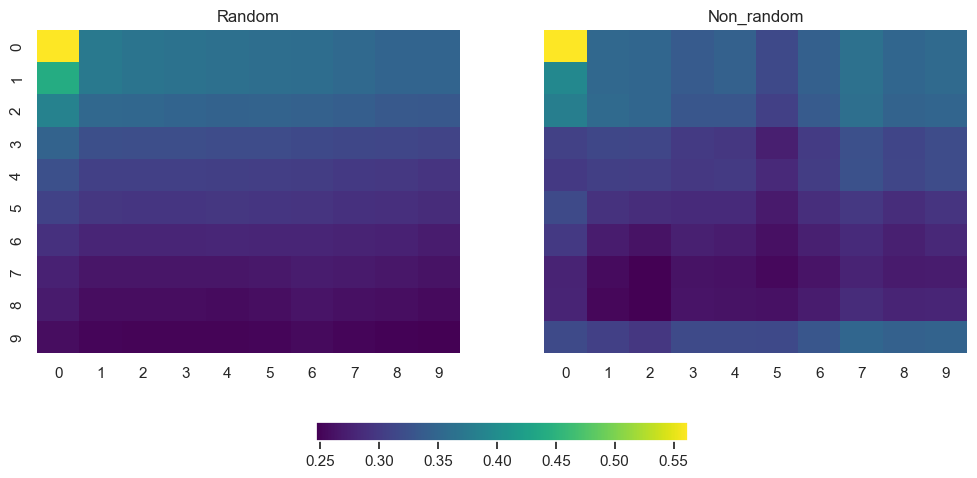

In [190]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

heatmap1 = sns.heatmap(matrix_part, cmap='viridis', ax=ax[0], cbar=False)
ax[0].set_title('Random')

heatmap2 = sns.heatmap(matrix2_part, cmap='viridis', ax=ax[1], cbar=False)
ax[1].set_title('Non_random')

# Add a shared colorbar to the plot
mappable = heatmap1.get_children()[0]
plt.colorbar(mappable, ax = ax,orientation = 'horizontal', shrink=0.4)

In [191]:
s = 20
i = 14
len(random_trial_data.loc[(random_trial_data[features] >= [s, i, 0.5]).all(axis=1)])

226

In [192]:
matrix_test = []
for s in range(1, 30):
    row = []
    for i in range(14):
        total_above_thresh = random_trial_data2.loc[(random_trial_data2[features] >= [s, i, 0.5]).all(axis=1)]
        good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < noise_thresh]
        row.append(len(total_above_thresh))
    matrix_test.append(row)

In [193]:
min(min(matrix_test))

423

Text(0.5, 1.0, 'Non-Random')

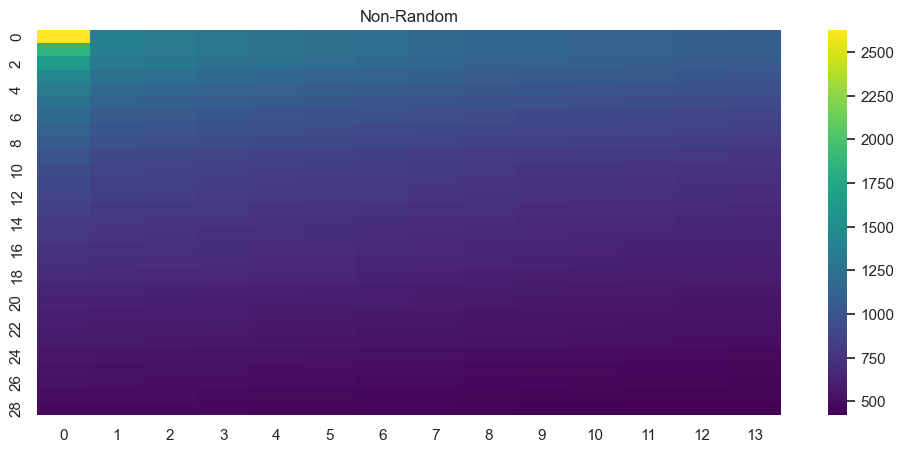

In [194]:
sns.heatmap(matrix_test, cmap='viridis')
plt.title("Non-Random")

## GridSearch

In [195]:
def good_cookies_above_thresh(df, min_interval, min_size, min_vers_clean, merge_noise):
    total_above_thresh = df.loc[(df[features] >= [min_size, min_interval, min_vers_clean]).all(axis=1)]
    good_aobve_thresh = total_above_thresh[total_above_thresh['merge_noise'] < merge_noise]
    return len(good_aobve_thresh)/len(total_above_thresh)

In [196]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize variables to keep track of the best parameter values and the largest difference
best_diff_params = None
best_ratio_params = None
largest_difference = None
largest_ratio = None

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0
    
    # Check if the current parameter values give a larger difference than the previous best
    if largest_difference is None or difference > largest_difference:
        largest_difference = difference
        best_diff_params = param_values

    if largest_ratio is None or ratio > largest_ratio:
        largest_ratio = ratio
        best_ratio_params = param_values

# Print the best parameter values and the largest difference
print("Best difference parameters:", {k: round(v, 3) for k,v in best_diff_params.items()})
print("Largest difference:", largest_difference)
print("Best ratio parameters:", {k: round(v, 3) for k,v in best_ratio_params.items()})
print("Largest ratio:", largest_ratio)

  0%|          | 0/5000 [00:00<?, ?it/s]

Best difference parameters: {'min_interval': 12, 'min_size': 9, 'min_vers_clean': 1.0, 'merge_noise': 0.02}
Largest difference: 0.5902115431645879
Best ratio parameters: {'min_interval': 11, 'min_size': 9, 'min_vers_clean': 0.778, 'merge_noise': 0.02}
Largest ratio: 0.9538228785620738


In [197]:
result_diff = {k: round(v, 3) for k,v in best_diff_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_diff_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_diff_params)
pd.DataFrame(result_diff, index=['best'])

min_interval  min_size  min_vers_clean  merge_noise    random  \
best            12         9             1.0         0.02  0.031915   

      non-random  
best    0.622126

In [198]:
result_diff = {k: round(v, 3) for k,v in best_ratio_params.items()}
result_diff['random'] = good_cookies_above_thresh(random_trial_data, **best_ratio_params)
result_diff['non-random'] = good_cookies_above_thresh(random_trial_data2, **best_ratio_params)
pd.DataFrame(result_diff, index=['best'])

min_interval  min_size  min_vers_clean  merge_noise    random  \
best            11         9           0.778         0.02  0.027548   

      non-random  
best    0.596577

In [199]:
# Define the ranges of parameter values to sample from
param_ranges = {
    'min_interval': np.arange(0, 14),
    'min_size': np.arange(1, 10),
    'min_vers_clean': np.linspace(0.5, 1, 10),
    'merge_noise': np.linspace(0, 0.2, 11)
}

# Set the number of random samples to generate
num_samples = 5000

# Initialize an empty dataframe to store the results
results_df = pd.DataFrame(columns=list(param_ranges.keys()) + ['random', 'non-random', 'difference', 'ratio'])

# Loop over all random samples of parameter values
for i in tqdm(range(num_samples)):
    # Sample random values for each parameter within the specified ranges
    param_values = {
        param_name: np.random.choice(param_range) for param_name, param_range in param_ranges.items()
    }
    
    # Apply the function to both dataframes with the current parameter values
    result1 = good_cookies_above_thresh(random_trial_data, **param_values)
    result2 = good_cookies_above_thresh(random_trial_data2, **param_values)
    
    # Compute the difference between the results
    difference = abs(result2 - result1)
    if result2 > 0:
        ratio = 1 - result1/result2
    else:
        ratio = 0.
    
    # Create a new dataframe with the current parameter values and the resulting difference
    row_df = pd.DataFrame({**param_values, 'random': result1, 'non-random': result2,
                           'difference': difference, 'ratio': ratio}, index=[0])
    
    # Concatenate the new dataframe to the results dataframe
    results_df = pd.concat([results_df, row_df], ignore_index=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [200]:
results_df['min_interval'] = results_df['min_interval'].astype('int')
results_df['min_size'] = results_df['min_size'].astype('int')

In [201]:
results_df.sort_values(by='ratio', ascending=False).head(10)

min_interval  min_size  min_vers_clean  merge_noise    random  \
4814            12         9        0.777778         0.02  0.028090   
4345            11         9        0.944444         0.02  0.028329   
556             13         9        0.555556         0.02  0.028249   
4780            13         9        0.777778         0.02  0.028249   
3660            12         9        0.888889         0.02  0.028249   
3315            12         9        0.888889         0.02  0.028249   
4848            12         9        0.888889         0.02  0.028249   
1350            12         9        0.944444         0.02  0.028902   
2067            11         8        0.722222         0.02  0.028796   
205             12         8        0.611111         0.02  0.029412   

      non-random  difference     ratio  
4814    0.595561    0.567471  0.952835  
4345    0.598259    0.569930  0.952648  
556     0.595771    0.567523  0.952585  
4780    0.595506    0.567257  0.952564  
3660    0.595062    0.566813  0.952528  
3315    0.595062    0.566813  0.952528  
4848    0.595062    0.566813  0.952528  
1350    0.597240    0.568338  0.951608  
2067    0.593496    0.564700  0.951481  
205     0.592506    0.563094  0.950360

<AxesSubplot: >

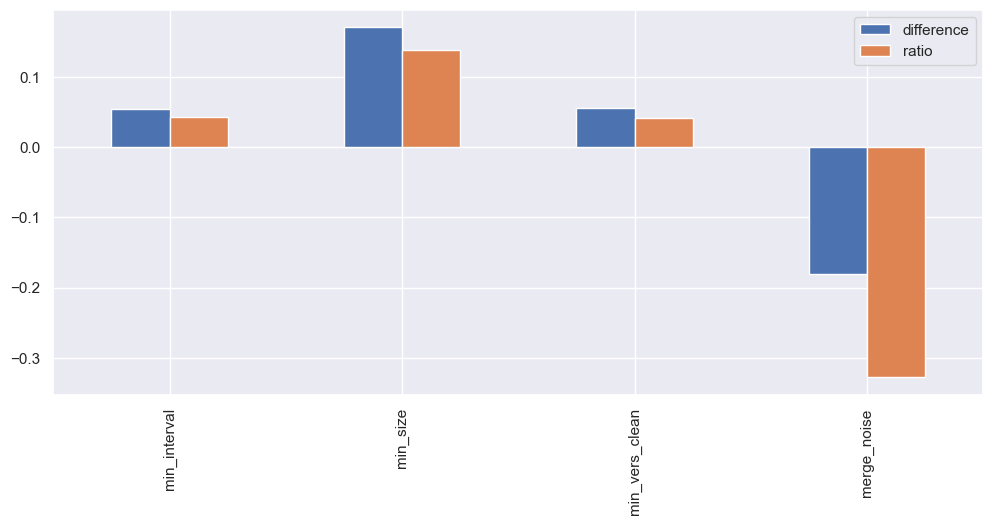

In [202]:
results_df.corr()[['difference', 'ratio']][:4].plot.bar()

## Restrict by longest living cookie

### LOTS

In [ ]:
df = cookie_time.head(15).reset_index().sort_values(by='min')

In [ ]:
longest_sequence(cookie_time.sample(15).reset_index(), name_str='iiqid', start_str='min', end_str='max')

In [ ]:
shots = cookie_time[(5 < cookie_time['interval']) & (cookie_time['interval'] < 20)].reset_index()

In [ ]:
# df = cookie_time.sample(15).reset_index()
df = shots.head(15)
chosen_ids = longest_sequence(df, name_str='iiqid', start_str='min', end_str='max')
plot_intervals(df, name_str='iiqid', start_str='min', end_str='max', color='green', highlight_ids=chosen_ids, highlight_color='red')

### Filtering

In [136]:
const = ['hh_id',"brand", "model", "os", "browser"]

In [289]:
cookies_data = cookie_time.reset_index().merge(data[const+['iiqid']], on='iiqid', how='left')

In [300]:
longest_cookie_per_home = cookies_data.groupby('hh_id').apply(lambda h: h.loc[h['interval'].idxmax(), 'iiqid'])

In [304]:
longest_cookie_per_home.name = 'iiqid'

In [308]:
longest_cookie_per_home_data = pd.merge(longest_cookie_per_home.reset_index(), cookies_data, on=['hh_id', 'iiqid'], how='inner')

<AxesSubplot: ylabel='Frequency'>

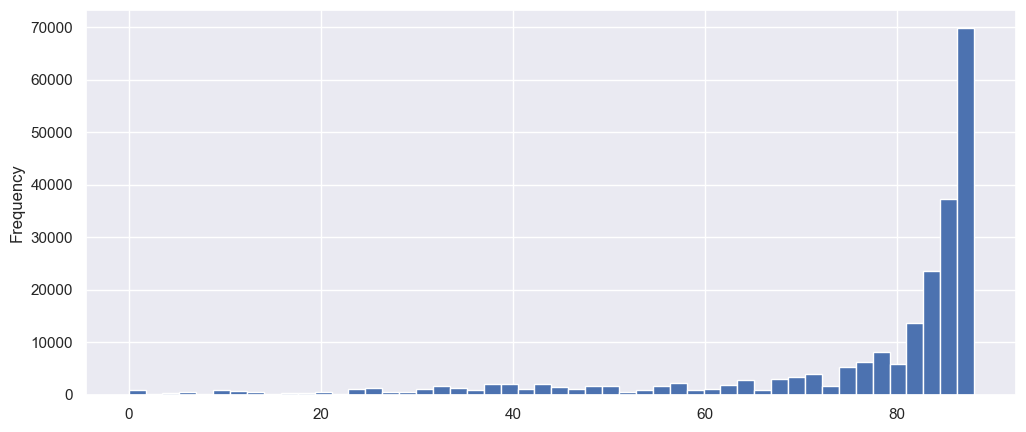

In [312]:
longest_cookie_per_home_data['interval'].plot.hist(bins=50)

In [137]:
def has_multiple_ua(house):
    user_agents = house[const].drop_duplicates()
    return len(user_agents) >= 2

In [234]:
filtered = data.groupby('hh_id', observed=True).filter(has_multiple_ua)

In [235]:
filtered_grouped_by = filtered.groupby(const, observed=True)
filtered_grouped = filtered_grouped_by.agg({'iiqid': ['nunique', pd.Series.mode]})

In [236]:
filtered_grouped.columns = ['nunique','iiqid']
filtered_grouped = filtered_grouped[filtered_grouped['nunique'] == 1].drop('nunique', axis=1)

In [237]:
grouped = filtered_grouped.iloc[:,0].drop_duplicates()

In [142]:
grouped = grouped.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [238]:
cookie_time_grouped = grouped.reset_index().merge(cookie_time, on='iiqid', how='left').set_index(const)

In [239]:
longest_in_hh = cookie_time_grouped.groupby(observed=True, level=0)['interval'].max().reset_index()

In [240]:
longest_in_const = pd.merge(cookie_time_grouped.reset_index(), longest_in_hh, 
         on=['hh_id', 'interval'], how='inner')

In [241]:
grouped_with_longest = cookie_time_grouped.reset_index().merge(longest_in_const, on='hh_id', how='left', suffixes=[None, '_best'])

In [242]:
filter_by_longest = grouped_with_longest[(((grouped_with_longest['min'] < grouped_with_longest['min_best'])
                       & (grouped_with_longest['max'] > grouped_with_longest['min_best']))
                      | ((grouped_with_longest['min'] > grouped_with_longest['min_best'])
                         & (grouped_with_longest['min'] < grouped_with_longest['max_best'])))]

In [245]:
filter_by_longest = filter_by_longest.set_index(const)

In [255]:
filter_by_longest = filter_by_longest.iloc[:,0].drop_duplicates()

In [257]:
filter_by_longest = filter_by_longest.groupby(level=0, observed=True).filter(lambda g: g.nunique() > 1)

In [263]:
filter_by_lingest.groupby(observed=True, level=0, group_keys=False)[const].apply(lambda g: any(g.nunique() > 1)).sum()

0

In [264]:
# two_from_each_houe = filter_by_lingest.groupby(observed=True, level=0, 
#                                                group_keys=False).apply(lambda g: g.sample(2))

In [22]:
trial_data = two_from_each_houe.reset_index()#.drop('hh_id', axis=1).reset_index()

In [23]:
trial_pairs = trial_data.groupby('hh_id')['iiqid'].agg(['min', 'max'])
trial_pairs.columns = ['first','second']

In [100]:
# max_session_length = 
data.groupby(

timestamp       iiqid       hh_id maid  partner_id          ip  \
6038     1674261805256  BnbWxgk98P  1279543812    7       11304  1279468148   
6039     1674261804149  BnbWxgk98P  1279543812    7       10253  1279468148   
6040     1674261804012  BnbWxgk98P  1279543812    7       11304  1279468148   
6041     1674168125336  BnbWxgk98P  1279543812    7       10253  1279468148   
6042     1674151252141  BnbWxgk98P  1279543812    7       10253  1279468148   
...                ...         ...         ...  ...         ...         ...   
8493028  1672768850981  XOJI7Q4xs2   800609212    7       15019   800618411   
8493029  1672768850769  XOJI7Q4xs2   800609212    7       15019   800618411   
8493030  1672764369273  XOJI7Q4xs2   800609212    7       15119   800618411   
8493031  1672764368603  XOJI7Q4xs2   800609212    7          14   800618411   
8493032  1672734489516  XOJI7Q4xs2   800609212    7          14   800609212   

         iscellip   cellispid       domain  is_house_ip_or_source_ip  ...  \
6038        False   195387531   -919294197                     False  ...   
6039        False   195387531    720825214                     False  ...   
6040        False   195387531  -1119659455                     False  ...   
6041        False   195387531   1953294843                     False  ...   
6042        False   195387531   1953294843                     False  ...   
...           ...         ...          ...                       ...  ...   
8493028     False  1937092536   1052828942                     False  ...   
8493029     False  1937092536     20133086                     False  ...   
8493030     False  1937092536   1967261364                     False  ...   
8493031     False  1937092536   1967261364                     False  ...   
8493032     False  1937092536  -1189039308                      True  ...   

               model       os osversion          browser advertisedbrowser  \
6038         firefox  windows        10  firefox desktop           Firefox   
6039         firefox  windows        10  firefox desktop           Firefox   
6040         firefox  windows        10  firefox desktop           Firefox   
6041         firefox  windows        10  firefox desktop           Firefox   
6042         firefox  windows        10  firefox desktop           Firefox   
...              ...      ...       ...              ...               ...   
8493028  pixel 7 pro  android        13    chrome mobile     Chrome Mobile   
8493029  pixel 7 pro  android        13    chrome mobile     Chrome Mobile   
8493030  pixel 7 pro  android        13    chrome mobile     Chrome Mobile   
8493031  pixel 7 pro  android        13    chrome mobile     Chrome Mobile   
8493032  pixel 7 pro  android        13    chrome mobile     Chrome Mobile   

        browserversion        type is_best_ip                    time is_hh  
6038              99.0     desktop      False 2023-01-21 00:43:25.256  True  
6039              99.0     desktop      False 2023-01-21 00:43:24.149  True  
6040              99.0     desktop      False 2023-01-21 00:43:24.012  True  
6041              99.0     desktop      False 2023-01-19 22:42:05.336  True  
6042              99.0     desktop      False 2023-01-19 18:00:52.141  True  
...                ...         ...        ...                     ...   ...  
8493028      108.0.0.0  smartphone      False 2023-01-03 18:00:50.981  True  
8493029      108.0.0.0  smartphone      False 2023-01-03 18:00:50.769  True  
8493030      108.0.0.0  smartphone      False 2023-01-03 16:46:09.273  True  
8493031      108.0.0.0  smartphone      False 2023-01-03 16:46:08.603  True  
8493032      108.0.0.0  smartphone      False 2023-01-03 08:28:09.516  True  

[842683 rows x 21 columns]